In [ ]:
# LinkNet with ResNet101 for multiclass semantic segmentation
!pip install tensorflow==2.1.0

In [ ]:
!pip install segmentation-models

In [3]:
# mount google drive here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Fetch the training, validation and testing dataset
import os
import numpy as np

dataPath  = '/content/drive/My Drive/Underwater_Segmentation_Research/Data'

trainPath       =  dataPath + '/Train'
testPath        =  dataPath + '/Test'
valPath         =  dataPath + '/Validate'

trainImgsFile   = 'trainingDataImgs.npy'
trainLabelsFile = 'trainingDataLabels.npy'

testImgsFile    = 'testingDataImgs.npy'
testLabelsFile  = 'testingDataLabels.npy'

valImgsFile     = 'validationDataImgs.npy'
valLabelsFile   = 'validationDataLabels.npy'

testImgs = None
testLabels = None

def getData(path,fileName):
  return np.load(path + "/" + fileName)

trainImgs   = getData(trainPath, trainImgsFile)
trainLabels = getData(trainPath, trainLabelsFile)

valImgs    = getData(valPath, valImgsFile)
valLabels  = getData(valPath, valLabelsFile)

print("Got train and validation data")
print(trainImgs.shape, valImgs.shape)
print(trainLabels.shape, valLabels.shape)

Got train and validation data
(1000, 480, 320, 1) (251, 480, 320, 1)
(1000, 480, 320, 1) (251, 480, 320, 1)


In [ ]:
# Create the model (without pre-trained ImageNet weights)
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm

# create the model
model = sm.Linknet('inceptionresnetv2', input_shape=(480, 320, 1), encoder_weights=None, classes=12, activation='softmax')
model.summary()


In [16]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

In [17]:
import tensorflow as tf
LOSS=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile('Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', UpdatedMeanIoU(num_classes=12)])

In [19]:
# Setup training parameters
BATCH = 16
EPOCHS = 30

# early stopping callback. It stops training when the loss does not change for 3 consecutive epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [20]:
# Start training the model
history = model.fit(trainImgs, trainLabels, epochs=EPOCHS, batch_size=BATCH, validation_data=(valImgs, valLabels))

Train on 1000 samples, validate on 251 samples
Epoch 1/30
1000/1000 [==============================] - 132s 132ms/sample - loss: 0.5573 - accuracy: 0.9053 - updated_mean_io_u_1: 0.0807 - val_loss: 0.6411 - val_accuracy: 0.9615 - val_updated_mean_io_u_1: 0.0801
Epoch 2/30
1000/1000 [==============================] - 97s 97ms/sample - loss: 0.1215 - accuracy: 0.9694 - updated_mean_io_u_1: 0.1185 - val_loss: 0.8685 - val_accuracy: 0.7321 - val_updated_mean_io_u_1: 0.0632
Epoch 3/30
1000/1000 [==============================] - 97s 97ms/sample - loss: 0.0937 - accuracy: 0.9725 - updated_mean_io_u_1: 0.1367 - val_loss: 0.3483 - val_accuracy: 0.9323 - val_updated_mean_io_u_1: 0.1023
Epoch 4/30
1000/1000 [==============================] - 97s 97ms/sample - loss: 0.0825 - accuracy: 0.9764 - updated_mean_io_u_1: 0.1986 - val_loss: 0.2400 - val_accuracy: 0.9289 - val_updated_mean_io_u_1: 0.1184
Epoch 5/30
1000/1000 [==============================] - 98s 98ms/sample - loss: 0.0627 - accuracy: 0.98

dict_keys(['loss', 'accuracy', 'updated_mean_io_u_1', 'val_loss', 'val_accuracy', 'val_updated_mean_io_u_1'])


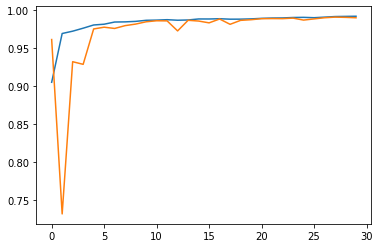

In [21]:
#  Plot the results
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

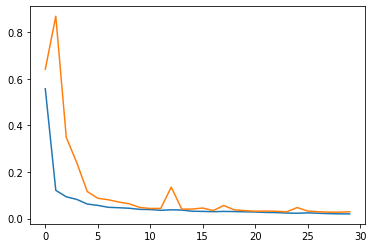

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

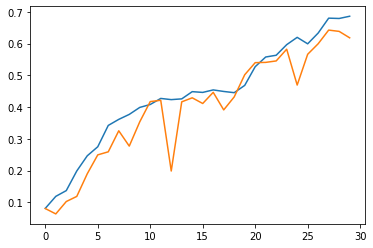

In [24]:
plt.plot(history.history['updated_mean_io_u_1'])
plt.plot(history.history['val_updated_mean_io_u_1'])

In [25]:
# get the testdata
testImgs   = getData(testPath, testImgsFile)
testLabels = getData(testPath, testLabelsFile)

In [26]:
model.evaluate(testImgs, testLabels)

617/617 [==============================] - 25s 40ms/sample - loss: 0.0291 - accuracy: 0.9900 - updated_mean_io_u_1: 0.6220


[0.029090520362799906, 0.98995405, 0.62195945]

In [27]:
# save the model weights
weightFileName = "LinkInceptoinResNetV2_30e_16b.h5"
weightPath = '/content/drive/My Drive/Underwater_Segmentation_Research/Weights/LinkNet'
model.save_weights(weightPath + "/" + weightFileName)


In [ ]:
model.load_weights(weightPath + "/" + weightFileName)
model.evaluate(testImgs, testLabels)

In [ ]:
modelFileName = "LinkInceptionResNetV2_30e_16b"
modelPath     = '/content/drive/My Drive/Underwater_Segmentation_Research/Models/LinkNet'
model.save(modelPath + "/" + modelFileName)

In [29]:
# Check the GPU configuration
!nvidia-smi

Wed May 26 12:36:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |  14870MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [31]:
y_preds = model.predict(testImgs)
y_preds = (y_preds >= 0.5).astype(np.uint8)

In [32]:
yPreds = tf.argmax(y_preds, axis=-1)
yPreds = yPreds.numpy()

In [33]:
# Compute mean of per-class IOU throughout the test images
num_classes=12
m = UpdatedMeanIoU(num_classes=12)
m.update_state(testLabels, y_preds)

print(f'Overall mean IOU is : {m.result().numpy()}')

# Values is the confusion matrix
values = np.array(m.get_weights()).reshape(num_classes, num_classes)

Overall mean IOU is : 0.6229597926139832


In [34]:
# compute the mean per-class IOU
numClasses = 12

classIOU = []

for i in range(numClasses):
  rowSum = np.sum(values[i,:])
  colSum = np.sum(values[:,i])
  denom = rowSum + colSum - values[i,i]
  iou = values[i,i]/denom
  classIOU.append(iou)

print(classIOU)
perClassIoU = np.array(classIOU)
print(np.mean(perClassIoU))

[0.9905393510265936, 0.7280122604752597, 0.5220941732733225, 0.6395299304104136, 0.5210475002509068, 0.587812616648003, 0.7106931642602163, 0.48563294190414685, 0.0, 0.8659304028444149, 0.5369551655862649, 0.8872697953023037]
0.6229597751651538


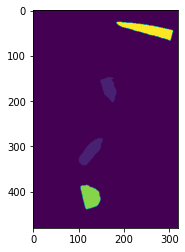

[ 0  1  9 11]


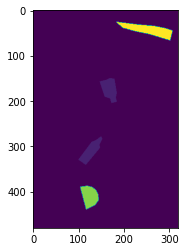

[ 0  1  9 11]


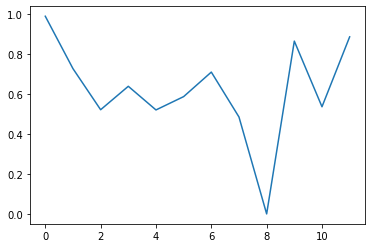

In [35]:
import matplotlib.pyplot as plt
i = 0
plt.imshow(yPreds[i])
plt.show()

print(np.unique(yPreds[i,:,:]))

plt.imshow(testLabels[i,:,:,0])
plt.show()

print(np.unique(testLabels[i,:,:,0]))

t = np.linspace(0,11,num=12)
plt.plot(t, perClassIoU)
plt.show()